In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import time

import random
import math
import torch
import scanpy as sc
from scipy.sparse import issparse
from torch.utils.data import Dataset
from anndata import AnnData
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
# from tqdm import tqdm, trange
from itertools import repeat
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR, ReduceLROnPlateau
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
from tqdm import tqdm

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, outdir=None):
    
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.loss_min = np.Inf
        self.model_file = os.path.join(outdir, 'model.pt') if outdir else None

    def __call__(self, loss, model):
        if np.isnan(loss):
            self.early_stop = True
        score = -loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_model(self.model_file)
        else:
            self.best_score = score
            self.save_checkpoint(loss, model)
            self.counter = 0

    def save_checkpoint(self, loss, model):
        if self.verbose:
            print(f'Loss decreased ({self.loss_min:.6f} --> {loss:.6f}).  Saving model ...')
        if self.model_file:
            torch.save(model.state_dict(), self.model_file)
        self.loss_min = loss


def elbo_SCALE(recon_x, x, gamma, c_params, z_params, binary=True):

    mu_c, var_c, pi = c_params;  # print(mu_c.size(), var_c.size(), pi.size())
    var_c += 1e-8
    n_centroids = pi.size(1)
    mu, logvar = z_params
    mu_expand = mu.unsqueeze(2).expand(mu.size(0), mu.size(1), n_centroids)
    logvar_expand = logvar.unsqueeze(2).expand(logvar.size(0), logvar.size(1), n_centroids)

    if binary:
        likelihood = -binary_cross_entropy(recon_x,
                                           x)  # ;print(logvar_expand.size()) #, torch.exp(logvar_expand)/var_c)
    else:
        likelihood = -F.mse_loss(recon_x, x)

    logpzc = -0.5 * torch.sum(gamma * torch.sum(math.log(2 * math.pi) + \
                                                torch.log(var_c) + \
                                                torch.exp(logvar_expand) / var_c + \
                                                (mu_expand - mu_c) ** 2 / var_c, dim=1), dim=1)

    logpc = torch.sum(gamma * torch.log(pi), 1)

    qentropy = -0.5 * torch.sum(1 + logvar + math.log(2 * math.pi), 1)

    logqcx = torch.sum(gamma * torch.log(gamma), 1)

    kld = -logpzc - logpc + qentropy + logqcx

    return torch.sum(likelihood), torch.sum(kld)



def kl_divergence(mu, logvar):

    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)


def elbo(recon_x, x, z_params, binary=True):

    mu, logvar = z_params
    kld = kl_divergence(mu, logvar)
    if binary:
        likelihood = -binary_cross_entropy(recon_x, x)
    else:
        likelihood = -F.mse_loss(recon_x, x)
    return torch.sum(likelihood), torch.sum(kld)

def binary_cross_entropy(recon_x, x):
    return -torch.sum(x * torch.log(recon_x + 1e-8) + (1 - x) * torch.log(1 - recon_x + 1e-8), dim=-1)


def build_mlp(layers, activation=nn.ReLU(), bn=False, dropout=0):

    net = []
    for i in range(1, len(layers)):
        net.append(nn.Linear(layers[i-1], layers[i]))
        if bn:
            net.append(nn.BatchNorm1d(layers[i]))
        net.append(activation)
        if dropout > 0:
            net.append(nn.Dropout(dropout))
    return nn.Sequential(*net)

In [20]:

class Encoder(nn.Module):
    def __init__(self, dims, bn=False, dropout=0):

        super(Encoder, self).__init__()

        [x_dim, h_dim, z_dim] = dims
        # self.hidden = build_mlp([x_dim, *h_dim], bn=bn, dropout=dropout)
        self.hidden = build_mlp([x_dim]+h_dim, bn=bn, dropout=dropout)
        self.sample = GaussianSample(([x_dim]+h_dim)[-1], z_dim)
        # self.sample = GaussianSample([x_dim, *h_dim][-1], z_dim)

    def forward(self, x):
        x = self.hidden(x)
        return self.sample(x)


class Decoder(nn.Module):
    def __init__(self, dims, bn=False, dropout=0, output_activation=nn.Sigmoid()):

        super(Decoder, self).__init__()

        [z_dim, h_dim, x_dim] = dims

        self.hidden = build_mlp([z_dim, *h_dim], bn=bn, dropout=dropout)
#         self.hidden = build_mlp([z_dim]+h_dim, bn=bn, dropout=dropout)
        self.reconstruction = nn.Linear([z_dim, *h_dim][-1], x_dim)
#         self.reconstruction = nn.Linear(([z_dim]+h_dim)[-1], x_dim)

        self.output_activation = output_activation

    def forward(self, x):
        x = self.hidden(x)
        if self.output_activation is not None:
            return self.output_activation(self.reconstruction(x))
        else:
            return self.reconstruction(x)

class DeterministicWarmup(object):

    def __init__(self, n=100, t_max=1):
        self.t = 0
        self.t_max = t_max
        self.inc = 1/n

    def __iter__(self):
        return self

    def __next__(self):
        t = self.t + self.inc

        self.t = self.t_max if t > self.t_max else t
        return self.t

    def next(self):
        t = self.t + self.inc

        self.t = self.t_max if t > self.t_max else t
        return self.t


###################
###################
class Stochastic(nn.Module):

    def reparametrize(self, mu, logvar):
        epsilon = torch.randn(mu.size(), requires_grad=False, device=mu.device)
        std = logvar.mul(0.5).exp_()
#         std = torch.clamp(logvar.mul(0.5).exp_(), -5, 5)
        z = mu.addcmul(std, epsilon)

        return z

class GaussianSample(Stochastic):

    def __init__(self, in_features, out_features):
        super(GaussianSample, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu = nn.Linear(in_features, out_features)
        self.log_var = nn.Linear(in_features, out_features)

    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        # print(log_var)
        # log_var = -F.relu(-log_var)
        # print(log_var)
        # assert False
        return self.reparametrize(mu, log_var), mu/10, log_var


class VAE(nn.Module):
    def __init__(self, dims, bn=False, dropout=0, binary=False):

        super(VAE, self).__init__()
        [x_dim, z_dim, encode_dim, decode_dim] = dims
        self.binary = binary
        if binary:
            decode_activation = nn.Sigmoid()
        else:
            decode_activation = None

        self.encoder = Encoder([x_dim, encode_dim, z_dim], bn=bn, dropout=dropout)
        self.decoder = Decoder([z_dim, decode_dim, x_dim], bn=bn, dropout=dropout, output_activation=decode_activation)

        self.reset_parameters()

    def reset_parameters(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x, y=None):

        z, mu, logvar = self.encoder(x)
        recon_x = self.decoder(z)

        return recon_x

    def loss_function(self, x):
        z, mu, logvar = self.encoder(x)
        recon_x = self.decoder(z)
        likelihood, kl_loss = elbo(recon_x, x, (mu, logvar), binary=self.binary)

        return (-likelihood, kl_loss)

    #     def load_model(self, path):
    #         pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
    #         model_dict = self.state_dict()
    #         pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    #         model_dict.update(pretrained_dict)
    #         self.load_state_dict(model_dict)

    def fit(self, dataloader,
            lr=0.002, 
            weight_decay=5e-4,
            device='cuda',
            beta = 1,
            n = 200,
            max_iter=30000,
            verbose=True,
            patience=100,
            outdir=None,
       ):

        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay) 
        Beta = DeterministicWarmup(n=n, t_max=beta)
        
        iteration = 0
        n_epoch = int(np.ceil(max_iter/len(dataloader)))
        early_stopping = EarlyStopping(patience=patience, outdir=outdir)
        # with tqdm(range(n_epoch), total=n_epoch, desc='Epochs') as tq:
        for epoch in range(n_epoch):
#                 epoch_loss = 0
                epoch_recon_loss, epoch_kl_loss = 0, 0
                # tk0 = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, desc='Iterations')
                for i, x in enumerate(dataloader):
#                     epoch_lr = adjust_learning_rate(lr, optimizer, iteration)
                    x = x.float().to(device)
                    optimizer.zero_grad()
                    
                    recon_loss, kl_loss = self.loss_function(x)
#                     loss = (recon_loss + next(Beta) * kl_loss)/len(x);
                    loss = (recon_loss + kl_loss)/len(x)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm(self.parameters(), 10) # clip
                    optimizer.step()
                    
                    epoch_kl_loss += kl_loss.item()
                    epoch_recon_loss += recon_loss.item()


                    
                    iteration+=1

    def encodeBatch(self, dataloader, device='cpu', out='z', transforms=None):
        output = []
        for x in dataloader:
            x = x.view(x.size(0), -1).float().to(device)
            z, mu, logvar = self.encoder(x)

            if out == 'z':
                output.append(z.detach().cpu())
            elif out == 'x':
                recon_x = self.decoder(z)
                output.append(recon_x.detach().cpu().data)
            elif out == 'logit':
                output.append(self.get_gamma(z)[0].cpu().detach().data)
            elif out == 'mu':
                output.append(mu.cpu().detach().data)
            elif out == 'log_var':
                output.append(logvar.cpu().detach().data)

        output = torch.cat(output).numpy()

        return output


class SCALE(VAE):
    def __init__(self, dims, n_centroids):
        super(SCALE, self).__init__(dims)
        self.n_centroids = n_centroids
        z_dim = dims[1]

        # init c_params
        self.pi = nn.Parameter(torch.ones(n_centroids) / n_centroids)  # pc
        self.mu_c = nn.Parameter(torch.zeros(z_dim, n_centroids))  # mu
        self.var_c = nn.Parameter(torch.ones(z_dim, n_centroids))  # sigma^2

    def loss_function(self, x):
        z, mu, logvar = self.encoder(x)
        recon_x = self.decoder(z)
        gamma, mu_c, var_c, pi = self.get_gamma(z)  # , self.n_centroids, c_params)
        likelihood, kl_loss = elbo_SCALE(recon_x, x, gamma, (mu_c, var_c, pi), (mu, logvar), binary=self.binary)

        return -likelihood, kl_loss

    def get_gamma(self, z):
        """
        Inference c from z

        gamma is q(c|x)
        q(c|x) = p(c|z) = p(c)p(c|z)/p(z)
        """
        n_centroids = self.n_centroids

        N = z.size(0)
        z = z.unsqueeze(2).expand(z.size(0), z.size(1), n_centroids)
        pi = self.pi.repeat(N, 1)  # NxK
        #         pi = torch.clamp(self.pi.repeat(N,1), 1e-10, 1) # NxK
        mu_c = self.mu_c.repeat(N, 1, 1)  # NxDxK
        var_c = self.var_c.repeat(N, 1, 1) + 1e-8  # NxDxK

        p_c_z = torch.exp(
            torch.log(pi) - torch.sum(0.5 * torch.log(2 * math.pi * var_c) + (z - mu_c) ** 2 / (2 * var_c),
                                      dim=1)) + 1e-10
        gamma = p_c_z / torch.sum(p_c_z, dim=1, keepdim=True)

        return gamma, mu_c, var_c, pi

    def init_gmm_params(self, dataloader, device='cpu'):

        gmm = GaussianMixture(n_components=1, covariance_type='diag')
        z = self.encodeBatch(dataloader, device)
        gmm.fit(z)
        self.mu_c.data.copy_(torch.from_numpy(gmm.means_.T.astype(np.float32)))
        self.var_c.data.copy_(torch.from_numpy(gmm.covariances_.T.astype(np.float32)))

In [21]:
def fit(model,
        dataloader,
        lr=0.002,
        var_lr=0.0002,
        weight_decay=5e-4,
        device='cuda',
        beta=1,
        n=2000,
        max_iter=30000,
        verbose=True,
        patience=100,
        outdir=None,
        ):
    self = model
    model.to(device)
    optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    if isinstance(self, VAE):
        optimizer = torch.optim.Adam([{'params': self.encoder.hidden.parameters(), 'lr': lr},
                                      {'params': self.encoder.sample.mu.parameters(), 'lr': lr},
                                      {'params': self.encoder.sample.log_var.parameters(), 'lr': var_lr},
                                      {"params": self.decoder.parameters(), 'lr': lr}],
                                     weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    Beta = DeterministicWarmup(n=n, t_max=beta)

    iteration = 0
    n_epoch = int(np.ceil(max_iter / len(dataloader)))
    early_stopping = EarlyStopping(patience=patience, outdir=outdir)
    # with tqdm(range(n_epoch), total=n_epoch, desc='Epochs') as tq:
    kl_loss_hist = []
    rec_loss_hist = []
    loss_hist = []
    for epoch in tqdm(range(n_epoch)):
        #                 epoch_loss = 0
        epoch_recon_loss, epoch_kl_loss, epoch_loss = 0, 0, 0
        
        for i, x in enumerate(dataloader):
            x = x.float().to(device)
            optimizer.zero_grad()

            recon_loss, kl_loss = self.loss_function(x)

            loss = recon_loss + next(Beta)*kl_loss
            # loss = recon_loss
            if torch.isnan(loss):
                return
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), 10)  # clip
            optimizer.step()

            epoch_kl_loss += kl_loss.item()/len(x)
            epoch_recon_loss += recon_loss.item()/len(x)
            epoch_loss += loss.item()/len(x)



            iteration += 1
        loss_hist.append(epoch_loss)
        kl_loss_hist.append(epoch_kl_loss)
        rec_loss_hist.append(epoch_recon_loss)


    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4*1), layout='constrained')
    axes[0].plot(loss_hist, label='loss')
    axes[0].set_title(f'loss:{loss_hist[-1]}')
    axes[1].plot(rec_loss_hist, label='rec loss')
    axes[1].set_title(f'rec loss:{rec_loss_hist[-1]}')
    axes[2].plot(kl_loss_hist, label='kl loss')
    axes[2].set_title(f'kl loss:{kl_loss_hist[-1]}')
    plt.show()

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

if torch.cuda.is_available():  # cuda device
    device = 'cuda'
    torch.cuda.set_device(0)
    print(1)
else:
    device = 'cpu'

data_dir = "data/"
data = pd.read_csv(os.path.join(data_dir, "data_label.csv"))
adata = sc.AnnData(data.iloc[:, 1:], obs=data.iloc[:,:1].astype('category'))
n_clusters = len(np.unique(adata.obs['Label']))

n_top_genes = 3000
target_sum = 1000

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000)
adata = adata[:, adata.var['highly_variable_rank']<n_top_genes]
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 278/278 [00:39<00:00,  7.05it/s]


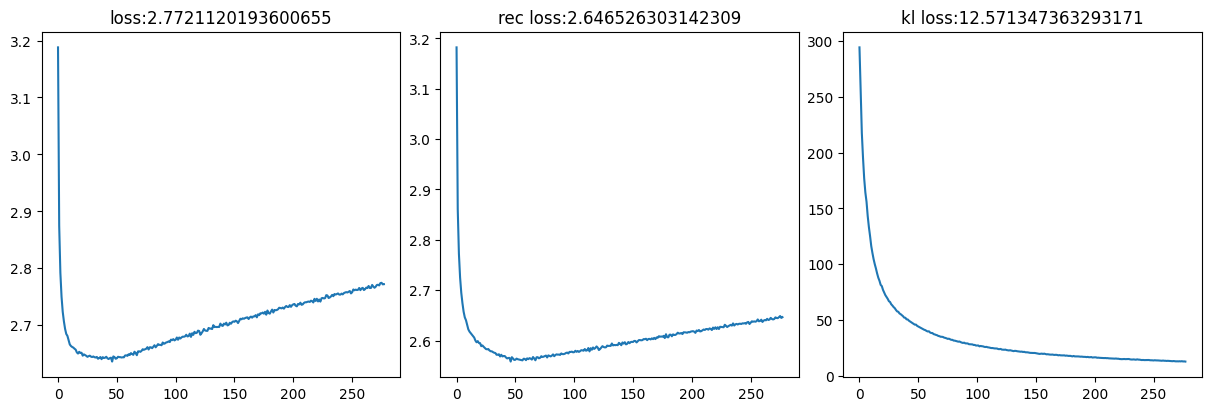

In [22]:
bn = False
dropout = 0
verbose = False
max_iter = 30000
outdir = None
lr = 0.0001

latent = 10
encode_dim = [1024, 128]
# decode_dim = [128, 1024]
decode_dim = [128, 1024]
# decode_dim = []
k = n_clusters

all_data_tensor = torch.from_numpy(adata.X).float()
# all_data_tensor = torch.from_numpy(adata.obsm['X_pca']).float()
dataloader = DataLoader(all_data_tensor, batch_size=32, drop_last=False, shuffle=False)
train_data_loader = DataLoader(all_data_tensor, batch_size=32, drop_last=True, shuffle=True)
input_dim = all_data_tensor.shape[-1]
dims = [input_dim, latent, encode_dim, decode_dim]
pretrain_model = VAE(dims, binary=False)
lr = 1e-4
# pretrain_model.encoder.sample.log_var.bias.data.fill_(-10)
fit(pretrain_model, train_data_loader,
                    # # bn = True,
                    # dropout = 0.1,
                    lr=lr,
                    var_lr=lr,
                    max_iter=max_iter,
                    verbose=verbose,
                    device=device,
                    outdir=outdir,
                    n=max_iter*100,
                  )

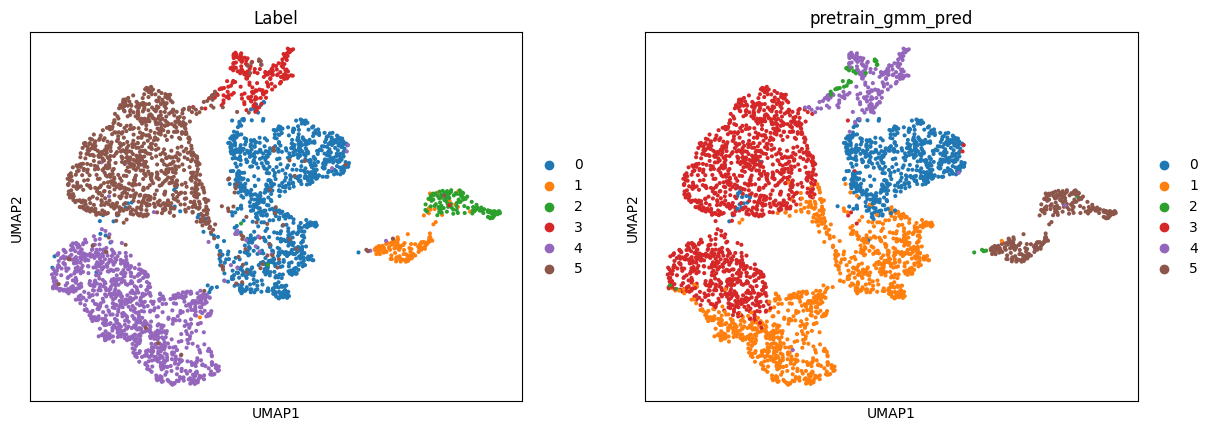

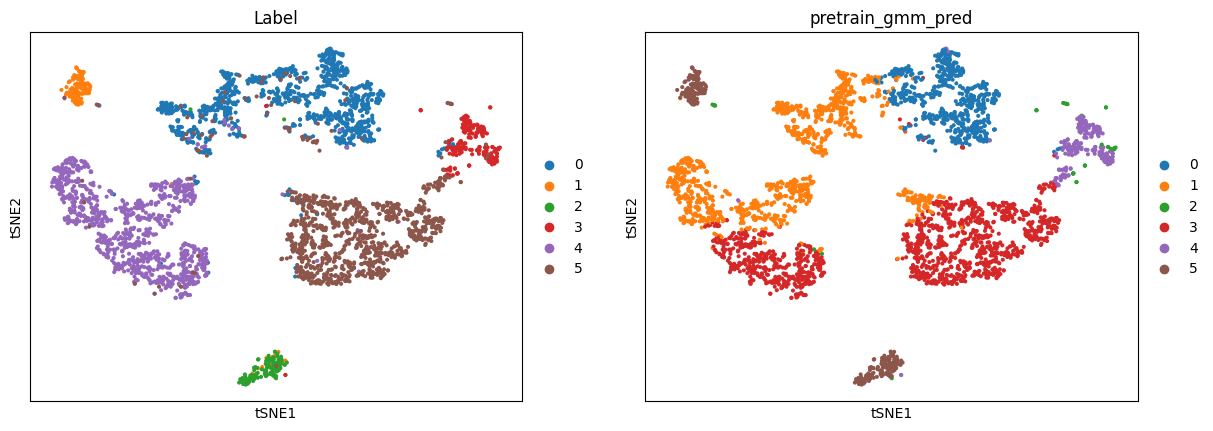

In [23]:
pretrain_model.eval()
pretrain_feat = pretrain_model.encodeBatch(dataloader, device=device, out='mu')
# adata.obsm['pretrain_feat'] = pretrain_feat
pretrain_pred = GaussianMixture(n_components=k, covariance_type='diag').fit_predict(pretrain_feat)
adata.obs['pretrain_gmm_pred'] = pretrain_pred
adata.obs['pretrain_gmm_pred'] = adata.obs['pretrain_gmm_pred'].astype(int).astype('category')
data = sc.AnnData(pretrain_feat, obs=adata.obs)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.tsne(data)
sc.pl.umap(data, color=['Label', 'pretrain_gmm_pred'])
sc.pl.tsne(data, color=['Label', 'pretrain_gmm_pred'])

/home/lcc/miniconda3/envs/py10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


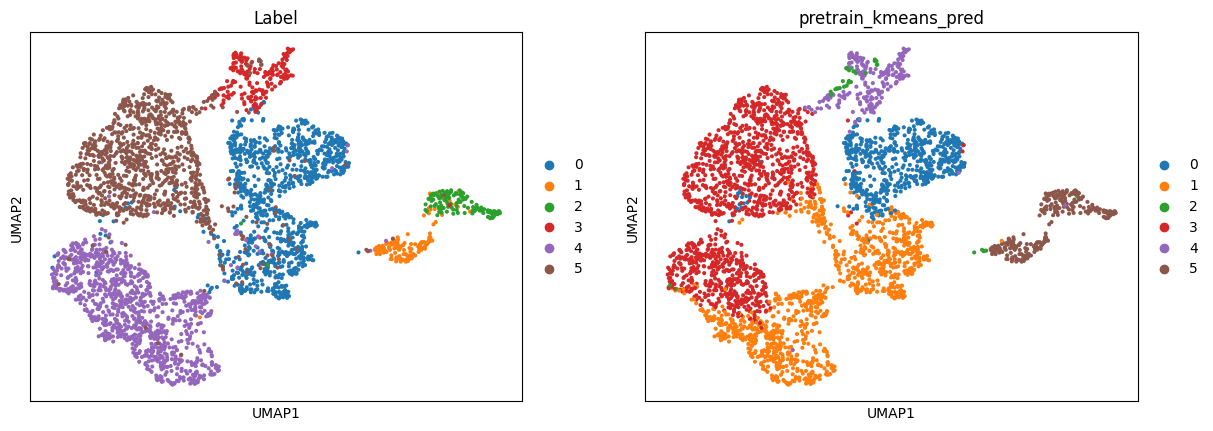

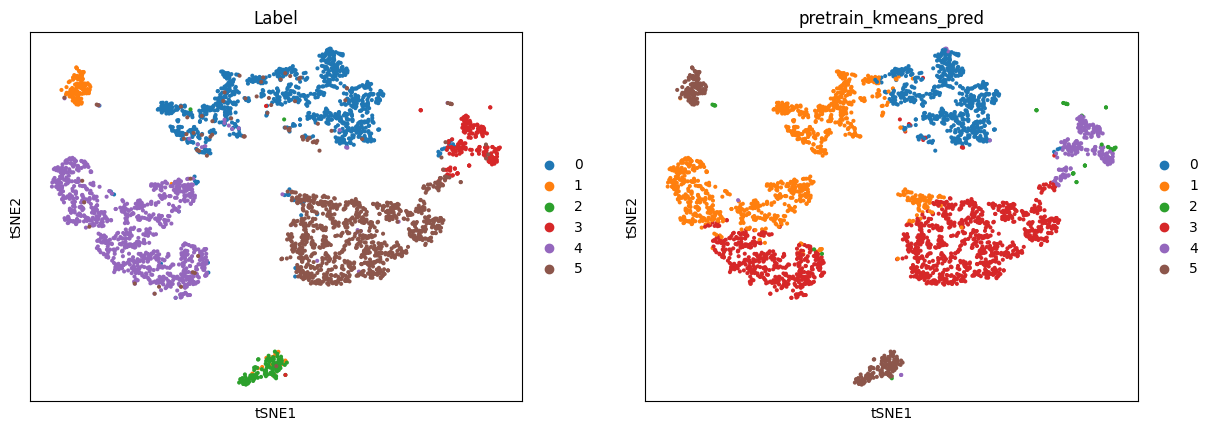

In [24]:
from sklearn.cluster import KMeans
kmeans_pretrain_pred = KMeans(n_clusters=k, random_state=0).fit_predict(pretrain_feat)
adata.obs['pretrain_kmeans_pred'] = pretrain_pred
adata.obs['pretrain_kmeans_pred'] = adata.obs['pretrain_kmeans_pred'].astype(int).astype('category')
data = sc.AnnData(pretrain_feat, obs=adata.obs)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.tsne(data)
sc.pl.umap(data, color=['Label', 'pretrain_kmeans_pred'])
sc.pl.tsne(data, color=['Label', 'pretrain_kmeans_pred'])

100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]


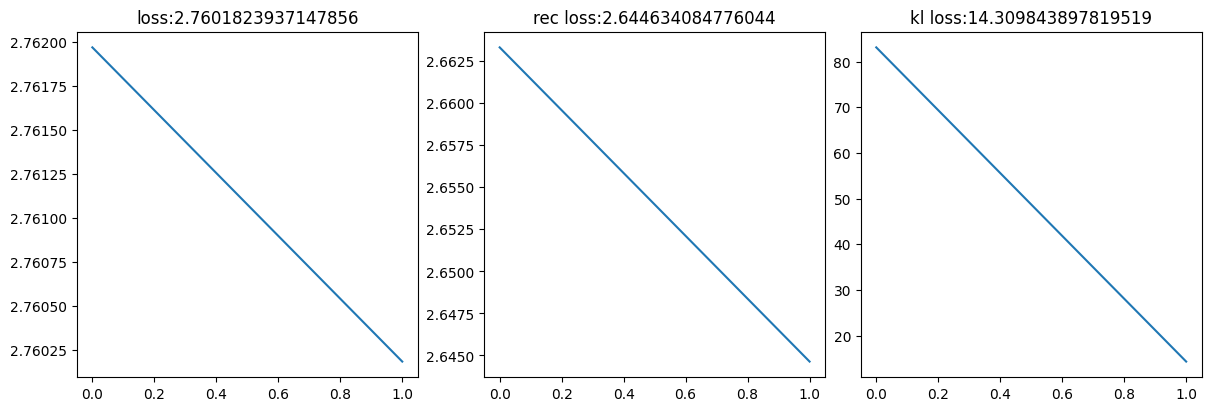

In [25]:
model = SCALE(dims, n_clusters)
model.load_state_dict(pretrain_model.state_dict(), strict=False)
model.init_gmm_params(dataloader)
max_iter = 200
fit(model, train_data_loader,
                    # # bn = True,
                    # dropout = 0.1,
                    lr=lr,
                    var_lr=lr,
                    max_iter=max_iter,
                    verbose=verbose,
                    device=device,
                    outdir=outdir,
                    n=max_iter*100,
                  )

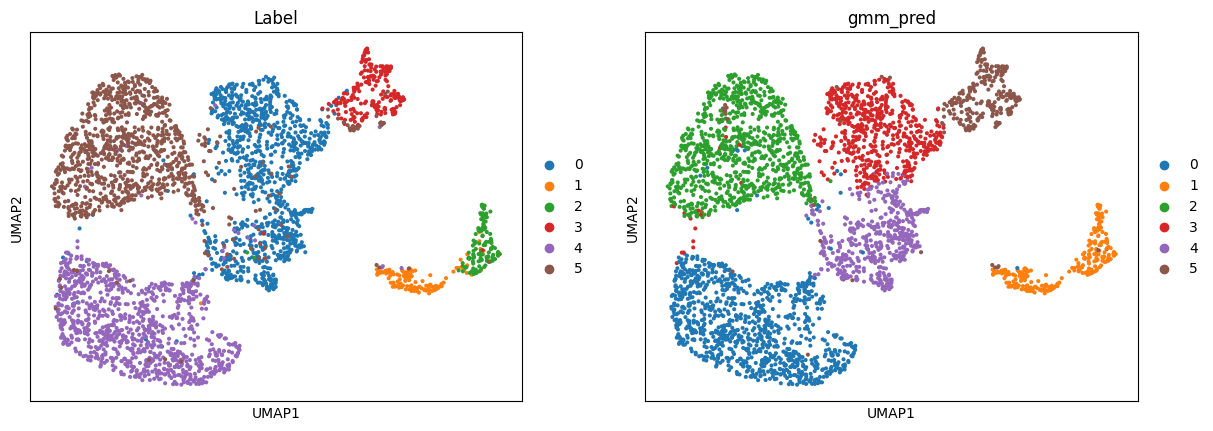

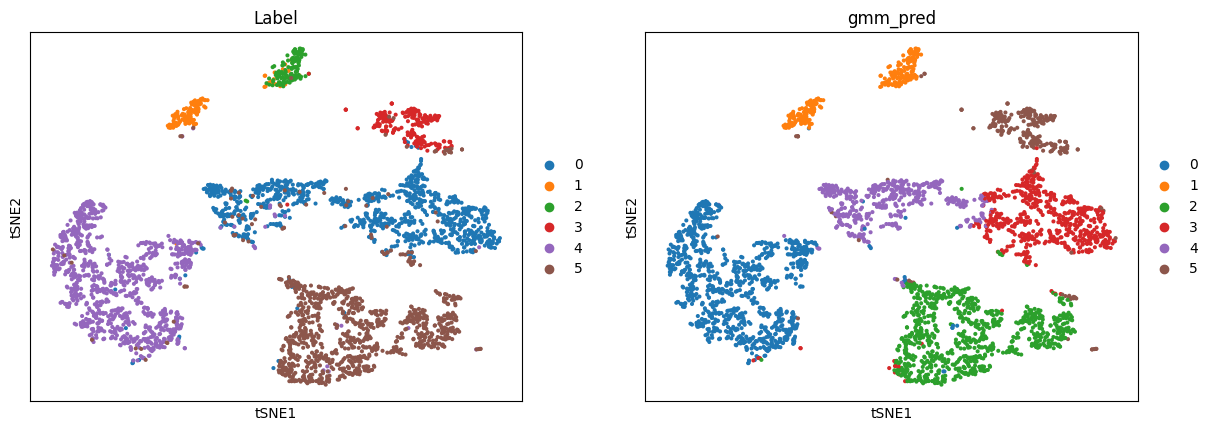

In [26]:
model.eval()
feat = model.encodeBatch(dataloader, device=device, out='mu')
# adata.obsm['pretrain_feat'] = pretrain_feat
pred = GaussianMixture(n_components=k, covariance_type='diag').fit_predict(pretrain_feat)
adata.obs['gmm_pred'] = pred
adata.obs['gmm_pred'] = adata.obs['gmm_pred'].astype(int).astype('category')
data = sc.AnnData(feat, obs=adata.obs)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.tsne(data)
sc.pl.umap(data, color=['Label', 'gmm_pred'])
sc.pl.tsne(data, color=['Label', 'gmm_pred'])